In [85]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor
from torch.optim import Adam
from torch.nn.functional import normalize
#from sklearn.preprocessing import MinMaxScaler

In [37]:
loss = nn.CrossEntropyLoss()

input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)

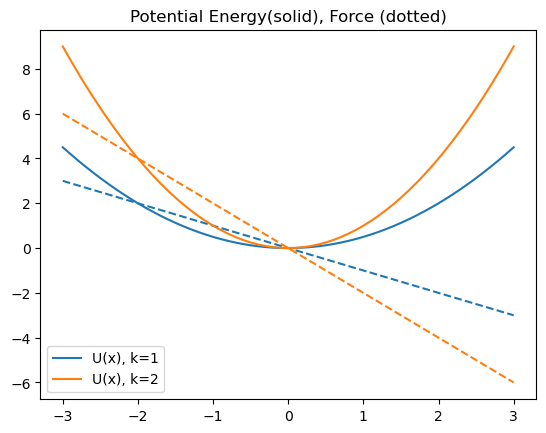

In [38]:
#this function returns the energy and force on a particle from a harmonic potential
def harmonic_oscillator_energy_force(x,k=1,x0=0):
    energy = 0.5*k*(x-x0)**2
    force = -k*(x-x0)
    return energy, force

#this function will plot the energy and force
#it is very general since it uses a special python trick of taking arbitrary named arguments (**kwargs) 
#and passes them on to a specified input function
def plot_energy_force(function, xmin=-3,xmax=3,spacing=0.1,**kwargs):
    x_points = np.arange(xmin,xmax+spacing,spacing)
    energies, forces = function(x_points,**kwargs)
    label = 'U(x)'
    for arg in kwargs:
        label=label+', %s=%s'%(arg,str(kwargs[arg]))
        p = plt.plot(x_points,energies,label=label)
        plt.plot(x_points,forces,label='',color=p[0].get_color(),linestyle='--')
        plt.legend(loc=0)
        plt.title("Potential Energy(solid), Force (dotted)")
        plt.savefig(str(function)+".png")
        
#we can plot the energy (solid) and forces (dashed) to see if it looks right
plot_energy_force(harmonic_oscillator_energy_force,k=1)
plot_energy_force(harmonic_oscillator_energy_force,k=2)

In [39]:
#this is step A
def position_update(x,v,dt):
    x_new = x + v*dt/2.
    return x_new


#this is step B
def velocity_update(v,F,dt):
    v_new = v + F*dt/2.
    return v_new

def random_velocity_update(v,gamma,kBT,dt):
    R = np.random.normal()
    c1 = np.exp(-gamma*dt)
    c2 = np.sqrt(1-c1*c1)*np.sqrt(kBT)
    v_new = c1*v + R*c2
    return v_new

def baoab(potential, max_time, dt, gamma, kBT, initial_position, initial_velocity,
                                        save_frequency=3, **kwargs ):
    x = initial_position
    v = initial_velocity
    t = 0
    step_number = 0
    positions = []
    velocities = []
    total_energies = []
    save_times = []
    
    while(t<max_time):
        # B
        potential_energy, force = potential(x,**kwargs)
        v = velocity_update(v,force,dt)
        # A
        x = position_update(x,v,dt)
        # O
        v = random_velocity_update(v,gamma,kBT,dt)
        # A
        x = position_update(x,v,dt)
        # B
        potential_energy, force = potential(x,**kwargs)
        v = velocity_update(v,force,dt)
        
        if step_number%save_frequency == 0 and step_number>0:
            e_total = .5*v*v + potential_energy

            positions.append(x)
            velocities.append(v)
            total_energies.append(e_total)
            save_times.append(t)
        
        t = t+dt
        step_number = step_number + 1
    
    return save_times, positions, velocities, total_energies   

(2083,)


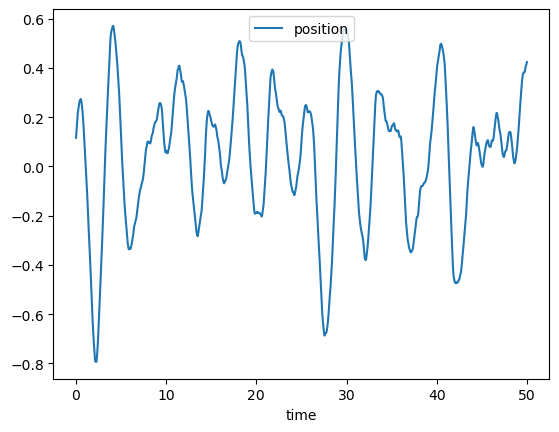

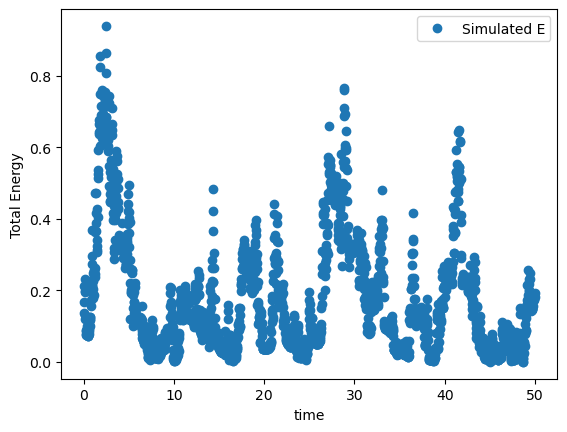

In [43]:
my_k = 2
my_max_time = 50
initial_position = .1
initial_velocity = .5

my_gamma=0.5
my_kBT=0.25
my_dt=0.008

times, positions, velocities, total_energies = baoab(
    harmonic_oscillator_energy_force,
    my_max_time, my_dt, my_gamma, my_kBT,
    initial_position, initial_velocity,
    k=my_k
)

plt.plot(times, positions, marker='', label='position', linestyle='-')

plt.xlabel('time')
plt.legend(loc='upper center')
plt.savefig("harm-v-x.png")
plt.figure()
plt.plot(times, total_energies, marker='o', linestyle='', label='Simulated E')
plt.xlabel('time')
plt.ylabel("Total Energy")
plt.legend()
plt.savefig("harm-e.png")

positions = np.array(positions)
print (np.shape(positions))


In [41]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

In [115]:
batch_size = 64
seq_length = 16
cutoff_pt = 1024
cutoff_len = 2048

pos_min = np.min(positions)
pos_max = np.max(positions)
print (pos_max, pos_min)
delta = np.abs((pos_max - pos_min))

positions = (positions - pos_min)/delta
for i, x in enumerate(positions):
    print (x)
    break
x, y = sliding_windows(positions, seq_length)
print (x.shape, y.shape)

training_input = torch.Tensor(x[:cutoff_pt]).reshape(cutoff_pt,1,-1)
training_target = torch.Tensor(positions[cutoff_pt:cutoff_len])
my_dataset = TensorDataset(training_input,training_target)

train_dataloader = DataLoader(my_dataset, batch_size)

for x,y in train_dataloader:
    print (x.shape, y.shape)
    break

1.3641722510124983 0.0
0.6670883955967134
(2066, 16) (2066,)
torch.Size([64, 1, 16]) torch.Size([64])


### Now that we have our data. lets construct a VAE

In [121]:
# Get cpu, gpu or mp devoce for training

device = (
    "cuda"
    if torch.cuda.is_available()
    #else "mps"
    #if torch.backends.mps.is_available()
    else "cpu"
)
print (f"Using device: {device}")


input_dim = seq_length
hidden_dim = 400
latent_dim = 200
epochs = 500

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            #nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            #nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
    def encode(self, x):
        x = self.encoder(x)
        mean =  self.mean_layer(x)
        log_var = self.logvar_layer(x)
        return mean, log_var
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + torch.exp(var)*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar
        
        

Using device: cpu


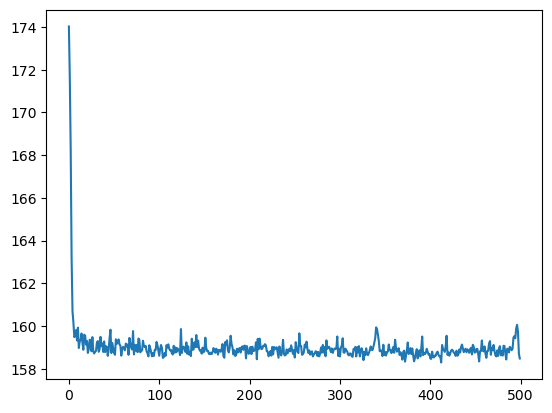

In [122]:
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
losses = []

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


def train(model, optimizer, epochs, device, x_dim=seq_length):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_dataloader):

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            #print (torch.min(x), torch.max(x), torch.min(x_hat), torch.max(x_hat))
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()
        losses.append(overall_loss/batch_size)

        #print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss


train(model, optimizer, epochs, device=device)
plt.plot (losses)

In [ ]:
### look at the latent space
Use latent space position and momenta and feed it to a simple RNN
use lyapunov indices in the loss function
predict(self, z)
a_new = rnn(z)
decde(z_new)